In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Baseline Models
- Selects a few stations from the preprocessed Fwy 405 N data
- Uses very basic prediction methods (e.g. using mean values)
- Considers MAE and RMSE on the test data
- Allows us to see baseline accuracy metrics

Note: must run the notebook `/preprocessing/preprocess.ipynb` to get the required data

In [2]:
station_meta = pd.read_csv('../data/processed/fwy_405_n_ds/meta.csv')
station_meta.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
0,771826,405,N,7,37,43000.0,.11,24.058,33.787054,-118.094505,0.303,ML,4,N. OF 605
1,717696,405,N,7,37,43000.0,.6,24.548,33.791829,-118.100867,0.495,ML,4,STUDEBAKER
2,718219,405,N,7,37,43000.0,1.1,25.048,33.796718,-118.107431,0.565,ML,4,PALO VERDE
3,717701,405,N,7,37,43000.0,1.73,25.678,33.802431,-118.115997,0.675,ML,4,WOODRUFF
4,717703,405,N,7,37,43000.0,2.45,26.398,33.802865,-118.128314,0.505,ML,4,BELLFLOWER 2


In [3]:
with open('../data/processed/fwy_405_n_ds/speeds.dat', 'rb') as f:
    station_data = pickle.load(f)

station_data.index = pd.to_datetime(station_data.index)
station_data.head()

,771826,717696,718219,717701,717703,718227,717706,717709,716632,771845,...,767351,717819,717823,767367,717825,717827,771808,771767,772011,772024
2021-05-01 00:00:00,70.2,68.6,69.3,70.8,68.4,72.7,72.0,72.8,72.2,70.5,...,65.4,69.5,69.8,64.3,68.8,70.7,63.6,64.2,69.4,67.7
2021-05-01 00:05:00,68.9,68.1,67.8,66.9,66.8,70.9,68.8,67.7,72.6,71.8,...,64.4,69.9,68.4,64.5,68.4,68.7,64.0,67.4,69.2,66.7
2021-05-01 00:10:00,69.8,68.7,68.7,65.3,66.9,71.2,69.0,66.8,71.3,66.4,...,62.0,67.5,67.4,64.6,69.4,68.4,60.2,61.9,69.9,69.4
2021-05-01 00:15:00,70.4,67.5,68.7,67.9,66.9,71.0,71.8,72.3,70.9,64.3,...,64.1,70.1,68.7,64.3,68.8,68.5,55.2,55.7,69.7,71.3
2021-05-01 00:20:00,70.0,69.2,69.2,67.9,69.1,71.4,71.8,74.8,70.4,67.3,...,64.9,71.2,69.9,65.1,69.8,70.5,49.0,47.7,70.7,70.0


### Train Test Split

In [4]:
# good example stations to try
#   717711  (difficult)
#   716659  (many random outliers)
#   761455  (periodic)
#   772455  (very periodic)

# select a station number to use
STATION = 772455

# use may, june as train data and july as test data
df = station_data[STATION]
train_data = df[df.index < pd.to_datetime('2021-07-01')].dropna()
test_data = df[df.index >= pd.to_datetime('2021-07-01')].dropna()

### Mean Fill
Simply predict the mean value

In [5]:
def predict_mean(train_data, test_data):
    mean = np.mean(train_data.values)

    return np.array([mean for x in range(test_data.shape[0])])

preds = predict_mean(train_data, test_data)

MAE:  17.679
RMSE: 18.615


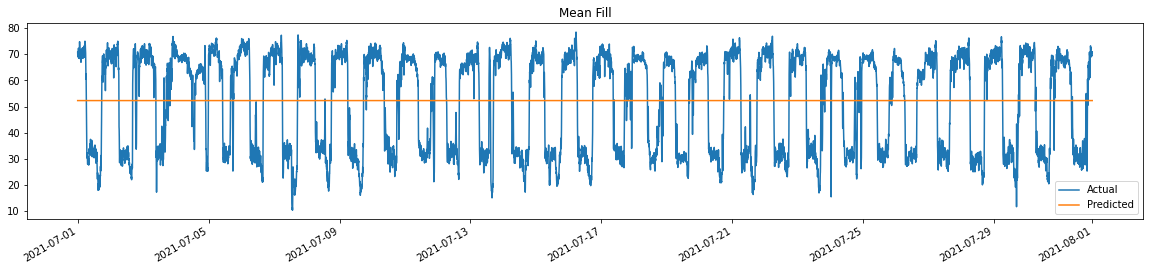

In [6]:
# results
print('MAE:  %.3f' % mean_absolute_error(test_data.values, preds))
print('RMSE: %.3f' % mean_squared_error(test_data.values, preds, squared=False))

p = pd.DataFrame(
    {'Actual': test_data.values, 'Predicted': preds}, 
    index=test_data.index 
).plot(figsize=(20,4), title='Mean Fill')

### Daily Mean
Predict using the mean value based on the time of day

In [7]:
def predict_daily_mean(train_data, test_data):
    df = train_data.to_frame().reset_index().rename(columns={'index': 'Time', train_data.name: 'Speed'})
    df['H'] = [x.hour for x in df['Time']]
    df['M'] = [x.minute for x in df['Time']]
    dm = df.groupby(['H', 'M']).mean()['Speed']

    preds = [dm[x.hour][x.minute] for x in test_data.index]  
    return np.array(preds)

preds = predict_daily_mean(train_data, test_data)

MAE:  6.170
RMSE: 9.767


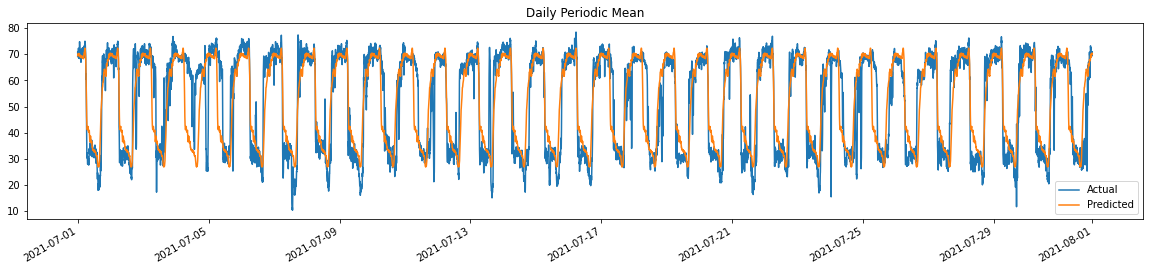

In [8]:
# results
print('MAE:  %.3f' % mean_absolute_error(test_data.values, preds))
print('RMSE: %.3f' % mean_squared_error(test_data.values, preds, squared=False))

p = pd.DataFrame(
    {'Actual': test_data.values, 'Predicted': preds}, 
    index=test_data.index
).plot(figsize=(20,4), title='Daily Periodic Mean')